In [1]:
import os
# os.chdir('/content/drive/MyDrive/Flickr Image Dataset')

In [2]:
INPUT_IMAGES_DIR = "/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/"
LABEL_PATH = "/kaggle/input/flickr-image-dataset/flickr30k_images/results.csv"
OUTPUT_PATH = "/kaggle/working"

In [3]:
import os
from PIL import Image
import gc
import numpy as np
import pandas as pd
import itertools
from tqdm.autonotebook import tqdm
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pickle
from torch.nn.utils.rnn import pad_sequence

import torch
import torchvision
from torch import nn
import torch.nn.functional as F

from collections import Counter
import nltk
nltk.download('punkt')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import sys
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
df = pd.read_csv(LABEL_PATH, delimiter="|")
df.columns = ['image', 'caption_number', 'caption']
df['caption'] = df['caption'].str.lstrip()
df['caption_number'] = df['caption_number'].str.lstrip()
df.loc[19999, 'caption_number'] = "4"
df.loc[19999, 'caption'] = "A dog runs across the grass ."
ids = [id_ for id_ in range(len(df) // 5) for i in range(5)]
df['id'] = ids
df.head()

,image,caption_number,caption,id
0,1000092795.jpg,0,Two young guys with shaggy hair look at their ...,0
1,1000092795.jpg,1,"Two young , White males are outside near many ...",0
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .,0
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .,0
4,1000092795.jpg,4,Two friends enjoy time spent together .,0


In [5]:
df["length"] = df["caption"].apply(lambda row: len(row.strip().split()))

In [6]:
import nltk
from collections import Counter

class Vocabulary():
    def __init__(self, df,vocab_threshold,vocab_file='vocab.pkl',
               start_word="<start>",end_word="<end>",unk_word="<unk>",pad="<pad>",vocab_from_file=False):
        self.vocab_threshold = vocab_threshold
        self.vocab_file = vocab_file
        self.start_word = start_word
        self.end_word = end_word
        self.unk_word = unk_word
        self.pad_word = pad
        self.vocab_from_file = vocab_from_file
        self.df = df
        self.get_vocab()
        
    def get_vocab(self):
        """Load the vocabulary from file OR build the vocabulary from scratch."""
        if os.path.exists(self.vocab_file) & self.vocab_from_file:
            with open(self.vocab_file, 'rb') as f:
                vocab = pickle.load(f)
                self.word2idx = vocab.word2idx
                self.idx2word = vocab.idx2word
            print('Vocabulary successfully loaded from vocab.pkl file!')
        else:
            self.build_vocab()
            with open(self.vocab_file, 'wb') as f:
                pickle.dump(self, f)
                
    def build_vocab(self):
        """Populate the dictionaries for converting tokens to integers (and vice-versa)."""
        self.init_vocab()
        self.add_word(self.start_word)
        self.add_word(self.end_word)
        self.add_word(self.unk_word)
        self.add_captions()

    def init_vocab(self):
        """Initialize the dictionaries for converting tokens to integers (and vice versa)."""
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0 

    def add_word(self, word):
        """Add a token to the vocabulary."""
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def add_captions(self):
        """Loop over training captions and add all tokens to the vocabulary that meet or exceed the threshold."""
        counter = Counter()
        x = df['caption'].apply(lambda row:counter.update(nltk.tokenize.word_tokenize(row)))
        words = [word for word, cnt in counter.items() if cnt>=self.vocab_threshold]
        for i, word in enumerate(words):
            self.add_word(word)

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx[self.unk_word]
        return self.word2idx[word]
    
    def __len__(self):
        return len(self.word2idx)

In [7]:
def collate_batch(batch):
    image_list,caption_list,caplen_list = [],[],[]
    for (image, caption,caplen) in batch:
        image_list.append(image)
        caption_list.append(caption)
        caplen_list.append(caplen)
    
    image_list = torch.stack(image_list)
    caplen_list = torch.tensor(caplen_list)
    caption_list = pad_sequence(caption_list, batch_first=True, padding_value=0)
    values, ind = torch.sort(caplen_list,dim=-1,descending=True)
    return image_list,caption_list[ind],values

In [8]:
class ImageCaptioningDataset(torch.utils.data.Dataset):
    def __init__(self,df,transform,mode,batch_size,vocab_threshold):
        self.caption_lengths = df['length']
        self.batch_size = batch_size
        self.df = df
        self.transform = transform
        self.mode = mode
        if mode == 'train':
            self.vocab = Vocabulary(df,vocab_threshold,'vocab.pkl1',vocab_from_file=False)
        elif (mode=='val') or (mode=='test'):
            self.vocab = Vocabulary(df,vocab_threshold,'vocab_pkl1',vocab_from_file=True)
    def __getitem__(self,index):
        if (self.mode == 'train') or (self.mode =='val'):
            image = Image.open(f"{INPUT_IMAGES_DIR}/{self.df['image'][index]}")
            image = self.transform(image)

            #Convert caption to tensor of word ids 
            tokens = nltk.tokenize.word_tokenize(self.df['caption'][index].lower())
            caption = []
            caption.append(self.vocab(self.vocab.start_word))
            caption.extend([self.vocab(token) for token in tokens])
            caption.append(self.vocab(self.vocab.end_word))
            caption = torch.Tensor(caption).long()

            caplen = self.df['length'][index]+2
            return (image,caption,caplen)

        else:
            p_image = Image.open(f"{INPUT_IMAGES_DIR}/{self.df['image'][index]}").convert('RGB')
            image = np.array(p_image)
            trans_image = self.transform(p_image)

            return image, trans_image,self.df['caption'][index]

    def get_train_indices(self):
        sel_length = np.random.choice(self.caption_lengths)
        all_indices = np.where([self.caption_lengths[i] == sel_length for i in np.arange(len(self.caption_lengths))])[0]
        indices = list(np.random.choice(all_indices, size=self.batch_size))
        return indices

    def __len__(self):
        return len(self.df['caption'])

In [9]:
mode ='train'
## TODO #1: Select appropriate values for the Python variables below.
batch_size = 128         # batch size
vocab_threshold = 6        # minimum word count threshold
embed_size = 512           # dimensionality of image and word embeddings
hidden_size = 512          # number of features in hidden state of the RNN decoder
num_epochs = 1             # number of training epochs (1 for testing)
save_every = 1             # determines frequency of saving model weights
print_every = 200          # determines window for printing average loss
log_file = 'training_log.txt'       # name of file with saved training loss and perplexity

In [10]:
transform_train = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    ])
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    ])

In [11]:
train, test =train_test_split(df,test_size=0.2,shuffle=True)
train_df,valid_df = train_test_split(train,test_size=0.2,shuffle=True)
train_df, valid_df, test = train_df.reset_index(drop=True), valid_df.reset_index(drop=True), test.reset_index(drop=True)

train_dataset = ImageCaptioningDataset(train_df,transform_train,mode,batch_size,vocab_threshold)
valid_dataset = ImageCaptioningDataset(valid_df,transform_train,'val',batch_size,vocab_threshold)
train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle=True,
                                               collate_fn=collate_batch,num_workers=2)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset,batch_size=batch_size,shuffle=True,
                                               collate_fn=collate_batch,num_workers=2)
# indices = train_dataset.get_train_indices()
# initial_sampler = torch.utils.data.sampler.SubsetRandomSampler(indices=indices)
#train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_sampler=torch.utils.data.sampler.BatchSampler(sampler=initial_sampler,batch_size=batch_size,drop_last=False))

In [12]:
test_dataset = ImageCaptioningDataset(test,transform_test,'test',1,0)
test_dataloader = torch.utils.data.DataLoader(test_dataset,batch_size=1,shuffle=True)

Vocabulary successfully loaded from vocab.pkl file!


In [13]:
len(train_dataloader.dataset.vocab),len(valid_dataloader.dataset.vocab),len(test_dataloader.dataset.vocab)

(7463, 7463, 7463)

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        resnet = torchvision.models.resnet50(pretrained='True')
        for param in resnet.parameters():
            param.requires_grad_(False)

        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features,embed_size)

  
    def forward(self, images):
        features = self.resnet(images)
        features = features.view(features.size(0),-1)
        features = self.embed(features)
        return features

In [78]:
class DecoderRNN(nn.Module):
    def __init__(self,embed_size,hidden_size,vocab_size):
        super(DecoderRNN,self).__init__()
        # The LSTM takes embedded word vectors (of a specified size) as input
        # and outputs hidden states of size hidden_dim
        self.lstm = nn.LSTM(input_size=embed_size,hidden_size=hidden_size, # LSTM hidden units 
                            num_layers=1, # number of LSTM layer
                            bias=True,# use bias weights b_ih and b_hh
                            batch_first=True,# input & output will have batch size as 1st dimension
                            dropout=0, # Not applying dropout 
                            bidirectional=False) # unidirectional LSTM
        #Embedding layer that turns words into a vector of a specified size
        self.embed = nn.Embedding(vocab_size,embed_size,padding_idx=0)
        # The linear layer that maps the hidden state output dimension
        # to the number of words we want as output, vocab_size
        self.linear = nn.Linear(hidden_size,vocab_size)
  
    def init_hidden(self, batch_size):
        """ At the start of training, we need to initialize a hidden state;
        there will be none because the hidden state is formed based on previously seen data.
        So, this function defines a hidden state with all zeroes
        The axes semantics are (num_layers, batch_size, hidden_dim)
        """
        return (torch.randn((1,batch_size,hidden_size),device=device),
                torch.randn((1,batch_size,hidden_size),device=device))

    def forward(self, features, captions,captions_length):
        """ Define the feedforward behavior of the model """
      
        # Discard the <end> word to avoid predicting when <end> is the input of the RNN
        captions = captions[:,:-1]
        # Initialize the hidden state
        batch_size = features.shape[0] # features is of shape (batch_size, embed_size)
        hidden = self.init_hidden(batch_size)
        # Create embedded word vectors for each word in the captions
        embeddings = self.embed(captions)# embeddings new shape : (batch_size, captions length - 1, embed_size)
        # Stack the features and captions
        embeddings = torch.cat((features.unsqueeze(1),embeddings),dim=1)
        embeddings = torch.nn.utils.rnn.pack_padded_sequence(embeddings, captions_length, batch_first=True)
        # embeddings new shape : (batch_size, caption length, embed_size)
        
        # Get the output and hidden state by passing the lstm over our word embeddings
        # the lstm takes in our embeddings and hidden state
        lstm_out, hidden = self.lstm(embeddings, hidden) # lstm_out shape : (batch_size, caption length, hidden_size)
        lstm_out, _ = torch.nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True)
        # Fully connected layer
        outputs = self.linear(lstm_out)# outputs shape : (batch_size, caption length, vocab_size)
        return outputs

  ##Greedy search 
    def sample(self,inputs):
        "accepts preprocessed image tensor(inputs) and returns predicted sentence(list of tensor ids of length max_len)"
        output = []
        batch_size = inputs.shape[0] # batch_size is 1 at inference, inputs shape : (1, 1, embed_size)
        hidden = self.init_hidden(batch_size)# Get initial hidden state of the LSTM
        while True:
            lstm_out, hidden = self.lstm(inputs,hidden) # lstm_out shape : (1, 1, hidden_size)
            outputs = self.linear(lstm_out) # outputs shape : (1, 1, vocab_size)
            outputs = outputs.squeeze(1) # outputs shape : (1, vocab_size)
            _, max_indice = torch.max(outputs,dim=1) #predict the most likely next word, max_indice shape:(1)
            output.append(max_indice.cpu().numpy()[0].item())# storing the word predicted
            if(max_indice == 1):
                # We predicted the <end> word, so there is no further prediction to do
                break
            ## Prepare to embed the last predicted word to be the new input of the lstm
            inputs = self.embed(max_indice) # inputs shape : (1, embed_size)
            inputs = inputs.unsqueeze(1) # inputs shape : (1, 1, embed_size)
            
        return output


In [26]:
import math
#The size of the vocabulary.
vocab_size = len(train_dataloader.dataset.vocab)

# Initialize the encoder and decoder. 
encoder = EncoderCNN(embed_size)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)

# Move models to GPU if CUDA is available. 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)
decoder.to(device)

# Define the loss function. 
criterion = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()

# TODO #3: Specify the learnable parameters of the model.
params = list(decoder.parameters()) + list(encoder.embed.parameters())

# TODO #4: Define the optimizer.
optimizer = torch.optim.Adam(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08)
# optimizer = torch.optim.Adam(params, lr=0.01, betas=(0.9, 0.999), eps=1e-08)
# optimizer = torch.optim.RMSprop(params, lr=0.01, alpha=0.99, eps=1e-08)

# Set the total number of training steps per epoch.
total_step = math.ceil(len(train_dataloader.dataset.caption_lengths) / batch_size)
val_step = math.ceil(len(valid_dataloader.dataset.caption_lengths)/batch_size)

In [ ]:
for epoch in range(1, num_epochs+1):
    for i_step in range(1, total_step+1):
        encoder.train()
        decoder.train()
        # Randomly sample a caption length, and sample indices with 
#         indices = train_dataloader.dataset.get_train_indices()
#         # Create and assign a batch sampler to retrieve a batch with the sampled 
#         new_sampler = torch.utils.data.sampler.SubsetRandomSampler(indices=indices)
#         train_dataloader.batch_sampler.sampler = new_sampler
        #obtain the batch
        images, captions, caplens = next(iter(train_dataloader))
        images = images.to(device)
        captions = captions.to(device)
#         caplens = caplens.to(device)

        decoder.zero_grad()
        encoder.zero_grad()

        features = encoder(images)
        outputs = decoder(features, captions,caplens)
        ou = outputs.shape[1]
        loss = criterion(outputs.contiguous().view(-1, vocab_size),captions[:,:ou].contiguous().view(-1))
        loss.backward()
        optimizer.step()
            
        stats = 'Epoch [%d/%d], Step [%d/%d], Loss: %.4f, Perplexity: %5.4f' % (epoch, num_epochs, i_step, total_step, loss.item(), np.exp(loss.item()))
        print('\r' + stats, end="")
    
    with torch.no_grad():
        for i_step in range(1,val_step+1):
            encoder.eval()
            decoder.eval()
            images, captions,caplens = next(iter(valid_dataloader))
            images = images.to(device)
            captions = captions.to(device)
#             caplens = caplens.to(device)

            features = encoder(images)
            outputs = decoder(features, captions,caplens)
            ou = outputs.shape[1]
            loss = criterion(outputs.contiguous().view(-1, vocab_size),captions[:,:ou].contiguous().view(-1))
            
            print('/n')
            stats = 'Epoch [%d/%d], Step [%d/%d], Loss: %.4f, Perplexity: %5.4f' % (epoch, num_epochs, i_step, val_step, loss.item(), np.exp(loss.item()))
            print('\r' + stats, end="")
        
    if epoch % save_every == 0:
        torch.save(decoder.state_dict(), 'decoder-%d.pkl' % epoch)
        torch.save(encoder.state_dict(), 'encoder-%d.pkl' % epoch)


Epoch [1/1], Step [795/795], Loss: 6.1498, Perplexity: 468.60661/n
Epoch [1/1], Step [1/199], Loss: 5.8612, Perplexity: 351.1606/n
Epoch [1/1], Step [2/199], Loss: 5.7253, Perplexity: 306.5126/n
Epoch [1/1], Step [3/199], Loss: 5.4580, Perplexity: 234.6296/n
Epoch [1/1], Step [4/199], Loss: 5.4809, Perplexity: 240.0653/n
Epoch [1/1], Step [5/199], Loss: 5.7051, Perplexity: 300.4043/n
Epoch [1/1], Step [6/199], Loss: 6.1479, Perplexity: 467.7315/n
Epoch [1/1], Step [7/199], Loss: 6.0526, Perplexity: 425.1981/n
Epoch [1/1], Step [9/199], Loss: 5.6634, Perplexity: 288.1146/n
Epoch [1/1], Step [10/199], Loss: 5.4317, Perplexity: 228.5457/n
Epoch [1/1], Step [11/199], Loss: 6.1174, Perplexity: 453.7027/n
Epoch [1/1], Step [12/199], Loss: 5.9067, Perplexity: 367.5050/n
Epoch [1/1], Step [13/199], Loss: 5.3882, Perplexity: 218.8039/n
Epoch [1/1], Step [14/199], Loss: 5.4387, Perplexity: 230.1449/n
Epoch [1/1], Step [35/199], Loss: 5.2414, Perplexity: 188.9378/n
Epoch [1/1], Step [36/199], Los

##Validation

In [156]:
encoder_file = 'encoder-1.pkl' 
decoder_file = 'decoder-1.pkl'

# TODO #3: Select appropriate values for the Python variables below.
embed_size = 512
hidden_size = 512

# The size of the vocabulary.
vocab_size = len(test_dataloader.dataset.vocab)

# Initialize the encoder and decoder, and set each to inference mode.
encoder1 = EncoderCNN(embed_size)
encoder1.eval()
decoder1 = DecoderRNN(embed_size, hidden_size, vocab_size)
decoder1.eval()

# Load the trained weights.
encoder1.load_state_dict(torch.load(encoder_file))
decoder1.load_state_dict(torch.load(decoder_file))

# Move models to GPU if CUDA is available.
encoder1.to(device)
decoder1.to(device)



DecoderRNN(
  (lstm): LSTM(512, 512, batch_first=True)
  (embed): Embedding(7463, 512, padding_idx=0)
  (linear): Linear(in_features=512, out_features=7463, bias=True)
)

In [30]:
# TODO #4: Complete the function.
def clean_sentence(output):
    list_string = []
    
    for idx in output:
        list_string.append(test_dataloader.dataset.vocab.idx2word[idx])
    list_string = list_string[1:-1] # Discard  and  words
    sentence = ' '.join(list_string) # Convert list of string to full string
    sentence = sentence.capitalize()  # Capitalize the first letter of the first word
    return sentence


In [158]:
def get_prediction():
    orig_image, image, caption = next(iter(test_dataloader))
    plt.imshow(np.squeeze(orig_image))
    plt.title('Sample Image')
    plt.show()
    image = image.to(device)
    features = encoder1(image).unsqueeze(1)
    output = decoder1.sample(features)    
    sentence = clean_sentence(output)
    print(f'Prediction: {sentence}'
         f'Ground Truth: {caption}')



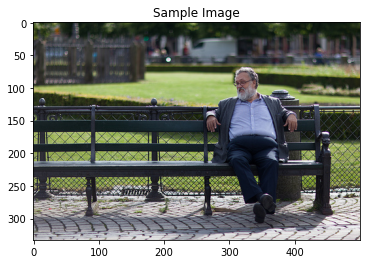

Prediction: A man in a white shirt is standing on a sidewalk .Ground Truth: ('A white-haired and bearded man reclines on a park bench .',)


In [159]:
get_prediction()

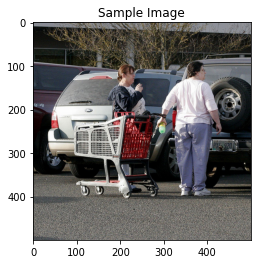

Prediction: A man in a black shirt and jeans is standing on a sidewalk .Ground Truth: ('Two women in a parking lot standing near a shopping cart .',)


In [160]:
get_prediction()

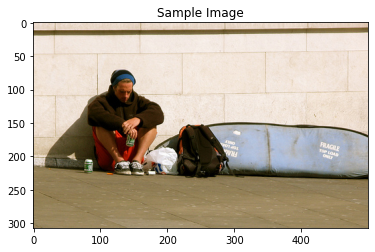

Prediction: A man in a black shirt and jeans is standing on a sidewalk .Ground Truth: ('A young man sits on the side of the road with his belongings .',)


In [161]:
get_prediction()

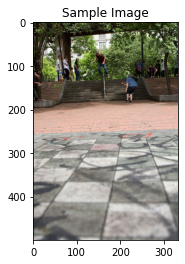

Prediction: A man in a white shirt is standing on a sidewalk .Ground Truth: ('Some skateboarders on stairs .',)


In [162]:
get_prediction()

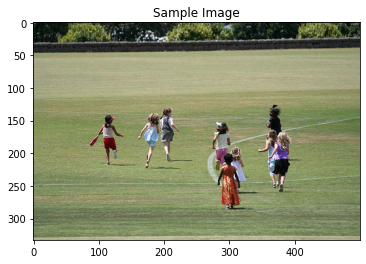

Prediction: A man in a white shirt is standing on a sidewalk .Ground Truth: ('A group of young girls running .',)


In [163]:
get_prediction()

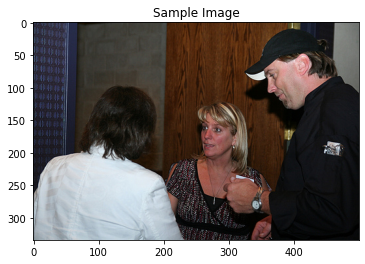

Prediction: A man in a white shirt is standing on a sidewalk .Ground Truth: ('Friends talking outside of a local bar .',)


In [164]:
get_prediction()

# Do not Run

Further Implementation: Using a transformer(DISTILBERT TRANSFORMER) as a text encoder, for the predicted caption from the LSTM, then projecting both Image Encodings and Captions Encodings and comparing each other, using the loss function to optimize both Image Encoder,Caption Encoder, Text Encoder

In [ ]:
!pip install transformers -q
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer
!pip install timm -q
import timm

In [ ]:
class CFG:
    debug = False
    batch_size = 128
    num_workers = 2
    head_lr = 1e-3
    image_encoder_lr = 1e-4
    text_encoder_lr = 1e-5
    weight_decay = 1e-3
    patience = 1
    factor = 0.8
    epochs = 2
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model_name = 'resnet50'
    image_embedding = 2048
    text_encoder_model = "distilbert-base-uncased"
    text_embedding = 768
    text_tokenizer = "distilbert-base-uncased"
    max_length = 200

    pretrained = True # for both image encoder and text encoder
    trainable = True # for both image encoder and text encoder
    temperature = 1.0

    # image size
    size = 224

    # for projection head; used for both image and text encoders
    num_projection_layers = 1
    projection_dim = 256 
    dropout = 0.1


In [ ]:
class AvgMeter:
    def __init__(self, name="Metric"):
        self.name = name
        self.reset()

    def reset(self):
        self.avg, self.sum, self.count = [0] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count

    def __repr__(self):
        text = f"{self.name}: {self.avg:.4f}"
        return text

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]



In [ ]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        resnet = torchvision.models.resnet50(pretrained='True')
        for param in resnet.parameters():
            param.requires_grad_(False)

        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features,embed_size)

  
    def forward(self, images):
        features = self.resnet(images)
        features = features.view(features.size(0),-1)
        features = self.embed(features)
        return features

In [ ]:
class ImageEncoder(nn.Module):
    """Encode Images to a fixed size vector"""
    def __init__(self,model_name=CFG.model_name,pretrained=CFG.pretrained,trainable=CFG.trainable):
        super().__init__()
        self.model = timm.create_model(model_name,pretrained,num_classes=0,global_pool="avg")
        for p in self.model.parameters():
            p.requires_grad = trainable

    def forward(self, x):
        return self.model(x)

In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self,embed_size,hidden_size,vocab_size):
        super(DecoderRNN,self).__init__()
        self.lstm = nn.LSTM(input_size=embed_size,hidden_size=hidden_size, num_layers=1,
                            bias=True,batch_first=True,dropout=0, bidirectional=False) 
    
        self.embed = nn.Embedding(vocab_size,embed_size)
        self.linear = nn.Linear(hidden_size,vocab_size)
  
    def init_hidden(self, batch_size):
        return (torch.zeros((1,batch_size,hidden_size),device=device),
                torch.zeros((1,batch_size,hidden_size),device=device))

    def forward(self, features, captions):
        captions = captions[:,:-1]
        batch_size = features.shape[0] 
        hidden = self.init_hidden(batch_size)
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1),embeddings),dim=1)
        lstm_out, hidden = self.lstm(embeddings, hidden) 
        outputs = self.linear(lstm_out)
        return outputs

    def sample(self,inputs):
        output = []
        batch_size = inputs.shape[0] 
        hidden = self.init_hidden(batch_size)
        while True:
            lstm_out, hidden = self.lstm(inputs,hidden) 
            outputs = self.linear(lstm_out) 
            outputs = outputs.squeeze(1) 
            _, max_indice = torch.max(outputs,dim=1) 
            output.append(max_indice.cpu().numpy()[0].item())
            if(max_indice == 1):
                break
            inputs = self.embed(max_indice) 
            inputs = inputs.unsqueeze(1) 
            
        return output


In [ ]:
class TextEncoder(nn.Module):
    def __init__(self, model_name="distilbert-base-uncased", pretrained=True, trainable=True):
        super().__init__()
        if pretrained:
            self.model = DistilBertModel.from_pretrained(model_name)
        else:
            self.model = DistilBertModel(config=DistilBertConfig())
    # for p in self.model.parameters():
    #   p.requires_grad = trainable

    #we are using the CLS token hidden representation as the sentence's embedding
        self.target_token_idx = 0

    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = output.last_hidden_state
        return last_hidden_state[:,self.target_token_idx,:]

In [ ]:
class ProjectionHead(nn.Module):
    def __init__(self,embedding_dim,projection_dim=256,dropout=0.1):
        super().__init__()
        self.projection = nn.Linear(embedding_dim,projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim,projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)

    def forward(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x+projected
        x = self.layer_norm(x)
        return x

In [ ]:
class CLIPModel(nn.Module):
    def __init__(self,tokenizer,EncoderCNN,DecoderRNN,temperature=CFG.temperature,image_embedding=CFG.image_embedding,text_embedding=CFG.text_embedding):
        super().__init__()
        self.tokenizer = tokenizer
        self.encodercnn = EncoderCNN
        self.decoderrnn = DecoderRNN
        self.image_encoder = ImageEncoder()
        self.text_encoder = TextEncoder()
        self.image_projection = ProjectionHead(embedding_dim=image_embedding)
        self.text_projection = ProjectionHead(embedding_dim=text_embedding)
        self.temperature = temperature

    def forward(self,images,captions):
        #Getting Image and and Text Features
        features = self.encodercnn(images)
        outputs = self.decoderrnn(features, captions)
        loss = criterion(outputs.contiguous().view(-1, vocab_size),captions.view(-1))
        features2 = self.encodercnn(images).unsqueeze(1)
        output2 = self.decoderrnn.sample(features2)    
        sentence = clean_sentence(output2,train_dataloader)
        z = self.tokenizer(sentence,padding=True,truncation=True,max_length=CFG.max_length)
        image_features = self.image_encoder(images)
        text_features = self.text_encoder(input_ids=z["input_ids"],attention_mask=z["attention_mask"])
        #Getting Image and Text Embeddings (with same dimension)
        image_embeddings = self.image_projection(image_features)
        text_embeddings = self.text_projection(text_features)
        #Calculating the Loss
        logits = (text_embeddings @ image_embeddings.T)/self.temperature
        images_similarity = image_embeddings @ image_embeddings.T
        texts_similarity = text_embeddings @ text_embeddings.T
        targets = torch.softmax((images_similarity+texts_similarity)/2*self.temperature,dim=-1)
        texts_loss = cross_entropy(logits, targets, reduction='none')
        images_loss = cross_entropy(logits.T,targets.T,reduction='none')
        loss = (images_loss + texts_loss + loss) / 3.0
        return loss.mean()

In [ ]:
def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction =='none':return loss
    elif reduction == "mean": return loss.mean()

In [ ]:
# TODO #4: Complete the function.
def clean_sentence(output,dataloader):
    list_string = []
    
    for idx in output:
        list_string.append(dataloader.dataset.vocab.idx2word[idx])
    list_string = list_string[1:-1] # Discard  and  words
    sentence = ' '.join(list_string) # Convert list of string to full string
    sentence = sentence.capitalize()  # Capitalize the first letter of the first word
    return sentence


In [ ]:
vocab_size = len(train_dataloader.dataset.vocab)
criterion = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()
tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)

# Initialize the encoder and decoder. 
embed_size = 512           
hidden_size = 512  
encoder = EncoderCNN(embed_size)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)



In [ ]:
def train_epoch(model,train_loader,optimizer):
    loss_meter = AvgMeter()
    tqdm_object = tqdm(train_loader,total=len(train_loader))
    for (images,captions) in tqdm_object:
        images, captions = images.to(device),captions.to(device)
        loss = model(images, captions)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        count = images.size(0)
        loss_meter.update(loss.item(),count)
        tqdm_object.set_postfix(train_loss=loss_meter.avg,lr=get_lr(optimizer))
    return loss_meter

def valid_epoch(model,valid_loader):
    loss_meter = AvgMeter()
    tqdm_object = tqdm(valid_loader,total=len(valid_loader))
    for (images, captions) in tqdm_object:
        images, captions = images.to(device),captions.to(device)
        loss = model(images, captions)
        count = images.size(0)
        loss_meter.update(loss.item(),count)
        tqdm_object.set_postfix(valid_loss=loss_meter.avg)
    return loss_meter



In [ ]:
model = CLIPModel(tokenizer,encoder,decoder).to(CFG.device)
params = [
    {"params":model.encodercnn.embed.parameters(),"lr":CFG.image_encoder_lr},
    {"params":model.decoderrnn.parameters(),"lr":0.001},
    {"params":model.image_encoder.parameters(),"lr":CFG.image_encoder_lr},
    {"params":model.text_encoder.parameters(),"lr":CFG.text_encoder_lr},
    {"params":itertools.chain(model.image_projection.parameters(),model.text_projection.parameters()),
      "lr":CFG.head_lr,"weight_decay":CFG.weight_decay}
]
optimizer = torch.optim.AdamW(params,weight_decay=0.)

best_loss = float('inf')
for epoch in range(CFG.epochs):
    print(f"Epoch: {epoch + 1}")
    model.train()
    train_loss = train_epoch(model,train_dataloader,optimizer)
    model.eval()

with torch.no_grad():
    valid_loss = valid_epoch(model,test_dataloader)
    if valid_loss.avg < best_loss:
        best_loss = valid_loss.avg
        torch.save(model.state_dict(),"best.pth")
    print("Saved Best Model!")
